In [1]:
# Image Generation using Stylegan pre-trained model

In this kernel, I will focus on trying out a pre-trained stylegan model.

Therefore, understanding of the background knowledge of gan should be preceded, and it is good to check in advance how stylegan is implemented through the official TensorFlow code. (We'll use PyTorch more simply.) So let's get started.

- [PyTorch🔥 GAN Basic Tutorial for beginner](https://www.kaggle.com/songseungwon/pytorch-gan-basic-tutorial-for-beginner)


And, this kernel uses [lernapparat's Jupyter notebook (which recreates the StyleGAN for use with the pretrained weights)](https://github.com/sw-song/lernapparat/blob/master/style_gan/pytorch_style_gan.ipynb) as the base code. I added some test code and refined the structure. Thanks to lernapparat for the nice code sharing.

[-->paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Karras_A_Style-Based_Generator_Architecture_for_Generative_Adversarial_Networks_CVPR_2019_paper.pdf)

![-->paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Karras_A_Style-Based_Generator_Architecture_for_Generative_Adversarial_Networks_CVPR_2019_paper.pdf)

## Main Reference
1. [PyTorch-GAN | Github/lernapparat | PyTorch implementation of the StyleGAN Generator](https://github.com/sw-song/lernapparat/blob/master/style_gan/pytorch_style_gan.ipynb)
2. [stylegan | Github/NVlabs | Official](https://github.com/NVlabs/stylegan)
3. [StyleGAN: Use machine learning to generate and customize realistic images](https://heartbeat.fritz.ai/stylegans-use-machine-learning-to-generate-and-customize-realistic-images-c943388dc672)

## Preview

![image](https://miro.medium.com/max/1400/1*mDA1ms7D5NrwKXp4r2CXQQ.png)

> Copying the styles corresponding to coarse spatial resolutions brings high-level aspects such as pose, general hair style, face shape, and eyeglasses from source B, while all colors (eyes, hair, lighting) and finer facial features resemble source A.

## Structure

![image](https://bloglunit.files.wordpress.com/2019/02/e18489e185b3e1848fe185b3e18485e185b5e186abe18489e185a3e186ba-2019-02-24-e1848be185a9e18492e185ae-3.43.31.png)

> The generator in a traditional GAN vs the one used by NVIDIA in the StyleGAN

## Index
```
Step 1. Import Libraries
Step 2. Design Layers
     2-a. linear layer
     2-b. convolution layer
     2-c. noise layer
     2-d. style modification layer
     2-e. pixel normalization layer
     2-f. blur layer
     2-g. upscaling layer
Step 3. Design Networks
     3-a. generator mapping network
     3-b. generator synthesis blocks
     3-c. generator synthesis network
Step 4. Define the Model (Image Generator)
     4-a. data flow : z to image
     4-b. load pre-trained weight
Step 5. Test the Model
     5-a. gpu setting
     5-b. input setting - grid
     5-c. input setting - latent z
     5-d. show samples
Step 6. Control Latent Vector
     6-a. first random latent vector + generate first image
     6-b. second random latent vector + generate second image
     6-c. half `z` + half `z`
     6-d. half `w` + half `w`
     6-e. Image Interpolation Comparison
```
---

### Step 1. Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
import pickle

import numpy as np

import IPython

### Step 2. Design Layers

**2-a. Linear Layer**

In [3]:
class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He init
        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)


> With this Class, Targeted initialization is performed for each layer. 
It allows generator to follow the targeted style distribution.

![image](https://bloglunit.files.wordpress.com/2019/02/e18489e185b3e1848fe185b3e18485e185b5e186abe18489e185a3e186ba-2019-02-24-e1848be185a9e18492e185ae-5.42.19.png?w=1222)

> TEST CODE :

In [4]:
gain = 2**(0.5)
gain

1.4142135623730951

In [5]:
he_std = gain*(512**(-0.5)) # input_size = 512
he_std

0.06250000000000001

In [6]:
lrmul = 1
init_std = 1.0/lrmul
print(init_std)
print('w_mul when use wscale :',he_std*init_std)

1.0
w_mul when use wscale : 0.06250000000000001


In [7]:
torch.randn(512,512)*init_std

tensor([[ 0.1076, -0.7939, -0.4321,  ...,  0.9864,  0.1274, -0.8583],
        [ 0.3899,  1.9551, -1.1269,  ..., -0.2912, -1.7589,  0.3885],
        [ 1.3759, -0.3279, -1.1856,  ..., -0.9414, -0.6811, -1.3129],
        ...,
        [ 0.9549, -1.7451, -1.2190,  ..., -1.3965, -0.3845,  0.0126],
        [ 0.8171,  0.6817, -0.6595,  ..., -2.1062,  0.0514, -0.2212],
        [ 0.6480, -0.4214,  0.4209,  ...,  0.4952, -1.8853, -1.5767]])

In [8]:
weight = torch.nn.Parameter(torch.randn(512,512)*init_std) # Parameter(..) ==> requires_grad=True
weight

Parameter containing:
tensor([[-1.7265, -0.1802, -1.5631,  ...,  0.2271,  0.7574, -1.3131],
        [ 1.4180,  1.9626, -1.4577,  ...,  0.6278,  0.8543, -1.3278],
        [ 0.5769,  0.4111,  0.0917,  ..., -0.7307, -1.3663, -0.7942],
        ...,
        [-0.4772, -1.9239,  0.3500,  ...,  1.0491,  0.8204, -0.0886],
        [ 0.1059,  0.7246,  0.1851,  ...,  0.8033,  1.8477,  0.4473],
        [ 0.8246, -0.2548, -2.0822,  ...,  0.0243,  0.9222,  2.8538]],
       requires_grad=True)

In [9]:
bias = torch.nn.Parameter(torch.zeros(512,512))
bias

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [10]:
w_mul = lrmul
b_mul = lrmul

F.linear(torch.randn(512,512), weight*w_mul, bias*b_mul)

tensor([[ 10.2663, -18.6461,  11.5665,  ..., -20.6236,  33.6656, -29.8090],
        [ 28.4765, -37.8117,  14.9127,  ..., -13.3983,   6.3728, -32.2677],
        [ 13.4382,  -8.6829,  14.7946,  ..., -12.3326,   1.7387,  -2.8774],
        ...,
        [ 24.8954,   4.4578, -23.6992,  ...,  11.0017,  50.7194,  23.5677],
        [-12.7635,  35.7635,   9.6186,  ...,  22.4397,  31.5008, -11.2752],
        [ -6.8198,  -9.5122,  42.9766,  ...,  -4.0476,  17.7658, -21.4911]],
       grad_fn=<AddmmBackward>)

**2-b. Convolution Layer**

In [11]:
class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He init
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        
        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            # this is the fused upscale + conv from StyleGAN, sadly this seems incompatible with the non-fused way
            # this really needs to be cleaned up and go into the conv...
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            # probably applying a conv on w would be more efficient. also this quadruples the weight (average)?!
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)
    
        if not have_convolution and self.intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)
        
        if self.intermediate is not None:
            x = self.intermediate(x)
        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

> Using the same metric(targeted initialization)

Let's look at the schematic again at this point. 

![image](https://www.researchgate.net/publication/343021405/figure/fig3/AS:915394470625280@1595258457162/Generator-architecture-of-the-StyleGAN-neural-network-1.png)

> For each block, 2 noises and 2 styles are continuously injected.

**2-c. Noise Layer**

In [12]:
class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None
    
    def forward(self, x, noise=None):
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            # here is a little trick: if you get all the noiselayers and set each
            # modules .noise attribute, you can have pre-defined noise.
            # Very useful for analysis
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x

![image](https://bloglunit.files.wordpress.com/2019/02/1_gwchaliormc1xlj7bh0zmg.png)

- The noise layer receives the channels and returns the channels to which the noise is applied.
- The noise layer adds gaussian noise of learnable standard deviation 

**2-d. Style Modification Layer**

In [13]:
class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)
        
    def forward(self, x, latent):
        style = self.lin(latent) # style => [batch_size, n_channels*2]
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)  # [batch_size, 2, n_channels, ...]
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x

![image](https://bloglunit.files.wordpress.com/2019/02/0_uqn4slmhrfykfmjs.png)

> TEST CODE :

In [14]:
lin = MyLinear(512, 3*2, 1.0, use_wscale=True)

In [15]:
latent1 = torch.from_numpy(np.random.randn(3,512).astype(np.float64))
latent2 = torch.from_numpy(np.random.randn(3,512).astype(np.float64))
latent = torch.cat([latent1,latent2], axis=0)

In [16]:
latent.size()

torch.Size([6, 512])

**2-e. Pixel Normalization Layer**

In [17]:
class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

**2-f. Blur Layer**

In [18]:
class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel=[1, 2, 1]
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride
    
    def forward(self, x):
        # expand kernel channels
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x


**2-g. Upscaling Layer**

In [19]:
def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        return upscale2d(x, factor=self.factor, gain=self.gain)

### Step 3. Design Networks

**3-a. Generator Mapping Network**

In [20]:
class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))
        
    def forward(self, x):
        x = super().forward(x)
        # Broadcast
        x = x.unsqueeze(1).expand(-1, 18, -1)
        return x

> sampling latent `z`(gaussian distribution) --> return `w` vector

> style information is contained in `w`


In [21]:
class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)

**3-b. Generator Synthesis Blocks**

In [22]:
class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):
        x = self.top_epi(x)
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x

In [23]:
class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            # called 'const' in tf
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale) # tweak gain to match the official implementation of Progressing GAN
        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        
    def forward(self, dlatents_in_range):
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

In [24]:
class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        # 2**res x 2**res # res = 3..resolution_log2
        super().__init__()
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                                 intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
            
    def forward(self, x, dlatents_in_range):
        x = self.conv0_up(x)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

**3-c. Generator Synthesis Network**

In [25]:
class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
        num_channels        = 3,            # Number of output color channels.
        resolution          = 1024,         # Output resolution.
        fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
        fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
        fmap_max            = 512,          # Maximum number of feature maps in any layer.
        use_styles          = True,         # Enable style inputs?
        const_input_layer   = True,         # First layer is a learned constant?
        use_noise           = True,         # Enable noise inputs?
        randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
        nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu'
        use_wscale          = True,         # Enable equalized learning rate?
        use_pixel_norm      = False,        # Enable pixelwise feature vector normalization?
        use_instance_norm   = True,         # Enable instance normalization?
        dtype               = torch.float32,  # Data type to use for activations and outputs.
        blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.
        ):
        
        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
                
            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels, num_channels, 1, gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))
        
    def forward(self, dlatents_in):
        # Input: Disentangled latents (W) [minibatch, num_layers, dlatent_size].
        # lod_in = tf.cast(tf.get_variable('lod', initializer=np.float32(0), trainable=False), dtype)
        batch_size = dlatents_in.size(0)       
        for i, m in enumerate(self.blocks.values()):
            if i == 0:
                x = m(dlatents_in[:, 2*i:2*i+2])
            else:
                x = m(x, dlatents_in[:, 2*i:2*i+2])
        rgb = self.torgb(x)
        return rgb

### Step 4. Define the Model (Image Generator)

**4-a. data flow : z to image**

In [26]:
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis())    
]))


> If latent z is put into g_mapping network, w is returned, and if the returned w is put into g_synthesis, an image is created. This process is chained sequentially and occurs one after another.

**4-b. load pre-trained weight**

In [27]:
import os
os.listdir('../input/ffhq-1024x1024-pretrained')

['karras2019stylegan-ffhq-1024x1024.for_g_all.pt']

In [28]:
g_all.load_state_dict(torch.load('../input/ffhq-1024x1024-pretrained/karras2019stylegan-ffhq-1024x1024.for_g_all.pt'))

<All keys matched successfully>

### Step 5. Test the Model

**5-a. gpu setting**

In [29]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all.eval()
g_all.to(device)

Sequential(
  (g_mapping): G_mapping(
    (pixel_norm): PixelNormLayer()
    (dense0): MyLinear()
    (dense0_act): LeakyReLU(negative_slope=0.2)
    (dense1): MyLinear()
    (dense1_act): LeakyReLU(negative_slope=0.2)
    (dense2): MyLinear()
    (dense2_act): LeakyReLU(negative_slope=0.2)
    (dense3): MyLinear()
    (dense3_act): LeakyReLU(negative_slope=0.2)
    (dense4): MyLinear()
    (dense4_act): LeakyReLU(negative_slope=0.2)
    (dense5): MyLinear()
    (dense5_act): LeakyReLU(negative_slope=0.2)
    (dense6): MyLinear()
    (dense6_act): LeakyReLU(negative_slope=0.2)
    (dense7): MyLinear()
    (dense7_act): LeakyReLU(negative_slope=0.2)
  )
  (g_synthesis): G_synthesis(
    (torgb): MyConv2d()
    (blocks): ModuleDict(
      (4x4): InputBlock(
        (epi1): LayerEpilogue(
          (top_epi): Sequential(
            (noise): NoiseLayer()
            (activation): LeakyReLU(negative_slope=0.2)
            (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine

**5-b. input setting - grid**

In [30]:
nb_rows = 3
nb_cols = 3
nb_samples = nb_rows * nb_cols

**5-c. input setting - latent z**

In [31]:
latents = torch.randn(nb_samples, 512, device=device)

In [32]:
latents

tensor([[-1.1059, -0.1975,  1.4449,  ..., -0.4892, -0.4627,  0.6409],
        [ 1.0472, -0.4095,  0.5718,  ...,  0.3386, -1.0572,  0.6917],
        [-2.1010, -1.1147,  1.6716,  ..., -0.5664,  0.1170, -1.3762],
        ...,
        [-0.3962, -0.0594,  0.6348,  ..., -0.5308, -0.8458,  0.8576],
        [-0.9807,  0.3151,  1.0131,  ...,  0.3482,  1.1162, -0.4794],
        [-0.9322,  0.6307, -1.5320,  ...,  0.9619,  0.1061, -1.4439]])

In [33]:
latents.shape

torch.Size([9, 512])

**5-d. show samples**

In [34]:
import torchvision
import matplotlib.pyplot as plt

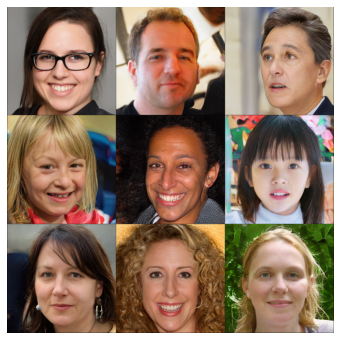

In [35]:
with torch.no_grad():
    imgs = g_all(latents)
    imgs = (imgs.clamp(-1, 1)+1)/2.0  # normalization to 0~1 range
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

plt.figure(figsize=(15,6))
plt.imshow(imgs.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

### Step 6. Control Latent Vector

**6-a. Tạo Sinh ảnh thứ nhất bằng vector latent z1**

In [36]:
latent1 = torch.randn(1, 512, device=device)
img1 = g_all(latent1)
img1 = img1.clamp(-1,1)+1/2.0
img1 = img1.cpu()

img1.shape

torch.Size([1, 3, 1024, 1024])

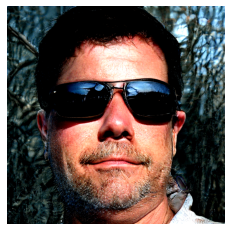

In [37]:
plt.imshow(img1.squeeze().permute(1,2,0).detach().numpy()) # drop batch (4dim -> 3dim)
plt.axis('off')
plt.show()

**6-b. Tạo sinh ảnh thứ hai bằng vector lantent z2**

In [38]:
latent2 = torch.randn(1, 512, device=device)
img2 = g_all(latent2)
img2 = img2.clamp(-1,1)+1/2.0
img2 = img2.cpu()

img2.shape

torch.Size([1, 3, 1024, 1024])

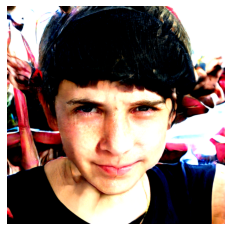

In [39]:
plt.imshow(img2.squeeze().permute(1,2,0).detach().numpy()) # drop batch (4dim -> 3dim)
plt.axis('off')
plt.show()

**6-c. Tạo sinh ảnh bằng cách kết hợp half `z`1 + half `z`2**

In [40]:
new_img = g_all(latent1*0.5 + latent2*0.5)
new_img = new_img.clamp(-1,1)+1/2.0
new_img = new_img.cpu()

new_img.shape

torch.Size([1, 3, 1024, 1024])

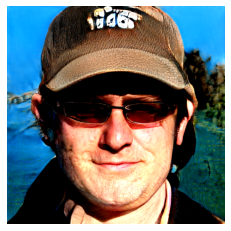

In [41]:
plt.imshow(new_img.squeeze().permute(1,2,0).detach().numpy()) 
plt.axis('off')
plt.show()

**6-d. Tạo sinh ảnh bằng styleGAN half `w`1 + half `w`2**

By the way, we actually have a w vector that passed through the G_mapping network. Let's try it.

In [42]:
g_mapping = g_all[0] # We can extract mapping network like this.
g_mapping

G_mapping(
  (pixel_norm): PixelNormLayer()
  (dense0): MyLinear()
  (dense0_act): LeakyReLU(negative_slope=0.2)
  (dense1): MyLinear()
  (dense1_act): LeakyReLU(negative_slope=0.2)
  (dense2): MyLinear()
  (dense2_act): LeakyReLU(negative_slope=0.2)
  (dense3): MyLinear()
  (dense3_act): LeakyReLU(negative_slope=0.2)
  (dense4): MyLinear()
  (dense4_act): LeakyReLU(negative_slope=0.2)
  (dense5): MyLinear()
  (dense5_act): LeakyReLU(negative_slope=0.2)
  (dense6): MyLinear()
  (dense6_act): LeakyReLU(negative_slope=0.2)
  (dense7): MyLinear()
  (dense7_act): LeakyReLU(negative_slope=0.2)
)

In [43]:
g_synthesis = g_all[1]# Similarly, synthesis network can be extracted like this.

In [44]:
w_1 = g_mapping(latent1)
w_2 = g_mapping(latent2)

The results through the MLP mapping network are as follows.

In [45]:
print(latent1.size(), w_1.size())
print(latent2.size(), w_2.size())

torch.Size([1, 512]) torch.Size([1, 18, 512])
torch.Size([1, 512]) torch.Size([1, 18, 512])


then, let's convert to image (half + half)

In [46]:
img3 = g_synthesis(w_1*0.5 + w_2*0.5)
img3 = img3.clamp(-1,1)+1/2.0
img3 = img3.cpu()

img3.shape

torch.Size([1, 3, 1024, 1024])

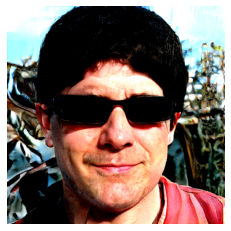

In [47]:
plt.imshow(img3.squeeze().permute(1,2,0).detach().numpy()) 
plt.axis('off')
plt.show()

Yes! I think this looks more like a `half+half`

And It is a really surprising result that it is estimated to be in the middle even by age.

**6-e. Image Interpolation Comparison**

In [48]:
itp_imgs = []

with torch.no_grad():
    for a in np.linspace(0, 1, 10):
        z = ((1-a) * latent1) + (a * latent2)
        result = g_all(z)
        result = result.clamp(-1,1)+1/2.0
        result = result.cpu()
        itp_imgs.append(result)

In [49]:
itp_imgs[0].size()

torch.Size([1, 3, 1024, 1024])

In [50]:
itp_imgs = torch.cat(itp_imgs)
itp_imgs.size()

torch.Size([10, 3, 1024, 1024])

In [51]:
grid_img = torchvision.utils.make_grid(itp_imgs, nrow=5)
grid_img.size()

torch.Size([3, 2054, 5132])

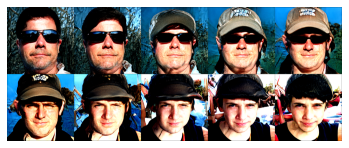

In [52]:
plt.imshow(grid_img.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

In [53]:
itp_imgs2 = []

with torch.no_grad():
    for a in np.linspace(0, 1, 10):
        w = ((1-a) * w_1) + (a * w_2)
        result2 = g_synthesis(w)
        result2 = result2.clamp(-1,1)+1/2.0
        result2 = result2.cpu()
        itp_imgs2.append(result2)

In [54]:
itp_imgs2[0].size()

torch.Size([1, 3, 1024, 1024])

In [55]:
itp_imgs2 = torch.cat(itp_imgs2)
itp_imgs2.size()

torch.Size([10, 3, 1024, 1024])

In [56]:
grid_img2 = torchvision.utils.make_grid(itp_imgs2, nrow=5)
grid_img2.size()

torch.Size([3, 2054, 5132])

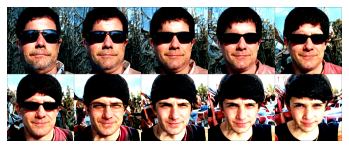

In [57]:
plt.imshow(grid_img2.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

Yes. It's so much more natural! Here we can see the strengths of stylegan. The traditional image generation model immediately generates an image from a random vector(gaussian distribution) z. That have showed how high the degree of freedom is, in other words, the low degree of feature separation(**It is said to be entangled**). stylegan captured this core 'style' through the mapping network, and we confirmed this through the interpolation results. 

in Abstract..
> The new generator improves the state-of-the-art in terms of traditional distribution quality metrics, leads to demonstrably better interpolation properties, and also better disentangles the latent factors of variation. To quantify interpolation quality and disentanglement, we propose two new, automated methods that are applicable to any generator architecture. 